In [1]:
import numpy as np
import tensorflow as tf
import time
import h5py
# from Network.PatchHandler3D import PatchHandler3D
from Network.PatchHandler3D_temporal import PatchHandler4D
from test_iterator import check_compatibility, load_indexes
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from IPython.display import display
from utils.evaluate_utils import *
from scipy.ndimage import binary_erosion
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = [10, 8]

In [ ]:
# def signal_to_noise_ratio(input, axis = 0):
#     m = input.mean(axis)
#     sd = input.std(axis=axis, ddof=ddof)
#     return np.where(sd == 0, 0, m/sd)

In [ ]:
# show radial sampled data
dynamical_mask = '../data/CARDIAC/M3_2mm_step2_static_dynamic.h5'
noisy_downsampled = '../data/CARDIAC/M3_2mm_step2_static_dynamic_noise_upsampled.h5'
data_1 = {}
data_2 = {}
vel_colnames = ['u', 'v','w']

with h5py.File(dynamical_mask, mode = 'r' ) as p1:
    with h5py.File(noisy_downsampled, mode = 'r' ) as p2:
            mask =  np.asarray(p1['mask'])
            temporal_mask = mask.copy()
            data_1['mask'] = temporal_mask
            data_2['mask'] = np.asarray(p2['mask']).squeeze()#create_temporal_mask(np.asarray(p2['mask']).squeeze(), p2['u'].shape[0])
            # temporal_mask = create_temporal_mask(mask.squeeze(), p1['u'].shape[0])
            for vel in vel_colnames:
                data_1[vel] = np.asarray(p1[vel])
                data_2[vel] = np.asarray(p2[vel])

                data_1[f'{vel}_fluid'] = np.multiply(data_1[vel], temporal_mask)
                data_2[f'{vel}_fluid']  = np.multiply(data_2[vel] , temporal_mask)

           

print(data_1['mask'].shape, data_2['mask'].shape)
with h5py.File('../results/Temporal4DFlowNet_20230313-0951/Testset_result_model4_2mm_step2_0951_temporal.h5', mode = 'r' ) as test1:
     print(test1['u_combined'].shape)

In [2]:
# look at sinc interpolation
upsampled_sinc ='../data/CARDIAC/M4_2mm_step2_static_dynamic_noise_sinc.h5'
noisy_downsampled = '../data/CARDIAC/M4_2mm_step2_static_dynamic_noise.h5'
data_1 = {}
data_2 = {}
vel_colnames = ['u', 'v','w']

with h5py.File(noisy_downsampled, mode = 'r' ) as p1:
    data_1['mask'] =  np.asarray(p1['mask'])
    temporal_mask = np.asarray(data_1['mask']).squeeze().copy()
    for vel in vel_colnames:
        data_1[vel] = np.asarray(p1[vel])
        data_1[f'{vel}_fluid'] = np.multiply(data_1[vel], temporal_mask)

with h5py.File(upsampled_sinc, mode = 'r' ) as p2:
    data_2['mask'] =  temporal_mask
    for vel in vel_colnames:
        data_2[vel] = np.asarray(p2[vel]).squeeze()



In [ ]:
print(temporal_mask.shape)
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_1[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_1[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

### In vivo data visualization

In [116]:
# look at in vivo data
in_vivo = '../data/PIA/BARCELONA/h5/sample_patient.h5'
in_vivo_upsampled = '../results/in_vivo/BARCELONA/20230405-1417_temporal.h5'
# in_vivo = '../data/PIA/THORAX/P01/h5/P01.h5'
# in_vivo_upsampled = '../results/in_vivo/THORAX/P01_masktest_20230405-1417_temporal.h5'
data_1 = {}
data_predicted = {}
vel_colnames = ['u', 'v','w']
mag_colnames = ['mag_u', 'mag_v', 'mag_w']
venc_colnames = [  'u_max', 'v_max', 'w_max']
vencs = {}

#load in-vivo data
with h5py.File(in_vivo, mode = 'r' ) as p1:
    data_1['mask'] =  np.asarray(p1['mask']).squeeze()
    print(p1.keys())
    for vel, venc in zip(vel_colnames, venc_colnames):
        vencs[venc] = np.asarray(p1[venc])
        data_1[vel] = np.asarray(p1[vel], dtype = float).squeeze()/np.max(p1[venc]) #TODO change this
        data_1[f'{vel}_fluid'] = np.multiply(data_1[vel], data_1['mask'])
    for mag in mag_colnames:
         data_1[mag] =  np.asarray(p1[mag]).squeeze()

#load prediction
with h5py.File(in_vivo_upsampled, mode = 'r' ) as h_pred:
    for vel, venc in zip(vel_colnames, venc_colnames):
        data_predicted[vel] = np.asarray(h_pred[f'{vel}_combined']) /np.max(vencs[venc]) 
        # add information considering only the fluid regions  
        data_predicted[f'{vel}_fluid'] =np.multiply(data_predicted[vel], data_1['mask'])

print(data_predicted['u'].shape)

<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
(30, 184, 204, 256)


In [117]:
def temporal_linear_interpolation_np_test(lr, hr_shape):
    T, x, y, z = hr_shape
    interpolate = np.zeros((hr_shape))
    interpolate[::2, :, :, :] = lr
    for t in range(0, T-2, 2):
        interpolate[1+t, :, :, :] = (interpolate[t, :, :, :] + interpolate[1+t+1, :, :, :]) /2

    return interpolate

In [118]:
#find lower and higher values to display velocity fields
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_1[vel][np.where(data_1['mask'] !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_1[vel][np.where(data_1['mask'] !=0)].flatten(), 0.99)

# interpolate data (take every second slice and interpolate them)
interpolate_linear = {}
interpolate_cubic = {}
for vel in vel_colnames:
    interpolate_linear[vel] = temporal_linear_interpolation_np_test(data_1[vel][::2], data_1[vel].shape)
    interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], data_1['mask'])

    # interpolate_cubic[vel] = temporal_cubic_interpolation(data_1[vel][::2], data_1[vel].shape)
    # interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], data_1['mask'])

error_pointwise, error_absolut = calculate_pointwise_error(data_predicted["u"], data_predicted["v"], data_predicted["w"], data_1["u"], data_1["v"] , data_1["w"], data_1["mask"])

# visualize given data
magn = np.sqrt(data_1['mag_u']**2 + data_1['mag_v']**2 + data_1['mag_w']**2)

In [ ]:

print(data_1.keys())
@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    plt.imshow(data_1['u'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Data, u')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(magn[frame, x, :, :], cmap ='Greys')#,vmin=min_v['u'], vmax = max_v['u'])
    plt.title('magnitude')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(data_1['mask'][frame, x, :, :], cmap ='Greys')#,vmin=min_v['u'], vmax = max_v['u'])
    plt.title('mask')
    plt.axis('off')
    plt.show()

dict_keys(['mask', 'u', 'u_fluid', 'v', 'v_fluid', 'w', 'w_fluid', 'mag_u', 'mag_v', 'mag_w'])


interactive(children=(IntSlider(value=5, description='frame', max=24), IntSlider(value=0, description='x', max…

#### Show comparison of prediction and original data

In [ ]:

@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    idx_slice = np.index_exp[frame, x, :, :]
    plt.subplot(3, 4, 1)
    plt.imshow(data_predicted['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title('u predicted')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(data_predicted['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title('v predicted')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(data_predicted['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title('w predicted')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(data_1['mask'][idx_slice], cmap ='Greys')
    plt.title('mask')
    plt.axis('off')

    plt.subplot(3, 4, 5)
    plt.imshow(data_1['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    # plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title('u')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(data_1['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    # plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title('v')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(data_1['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    # plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title('w')
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(magn[idx_slice], cmap ='Greys')
    plt.title('magnitude')
    plt.axis('off')

    plt.subplot(3, 4, 9)
    plt.imshow(np.abs(data_1['u_fluid'][idx_slice]- data_predicted['u_fluid'][idx_slice]), vmin = min_v['u'], vmax = max_v['u'], cmap = 'coolwarm')
    plt.title('abs diff u, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(np.abs(data_1['v_fluid'][idx_slice] - data_predicted['v_fluid'][idx_slice]), vmin = min_v['v'], vmax = max_v['v'], cmap = 'coolwarm')
    plt.title('abs diff v, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 11)
    plt.imshow(np.abs(data_1['w_fluid'][idx_slice] -data_predicted['w_fluid'][idx_slice]), vmin = min_v['w'], vmax = max_v['w'], cmap = 'coolwarm')
    plt.title('abs diff w, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 12)
    plt.imshow(error_pointwise[idx_slice], cmap = 'coolwarm')
    plt.title('relative error')
    plt.axis('off')


    plt.tight_layout()


    plt.show()

interactive(children=(IntSlider(value=5, description='frame', max=24), IntSlider(value=0, description='x', max…

#### Show relative error of prediction

max/min before tanh 170.8812497495527 0.0
max/min after tanh 1.0 0.0
max/min before tanh 264.7010552423145 0.0
max/min after tanh 1.0 0.0


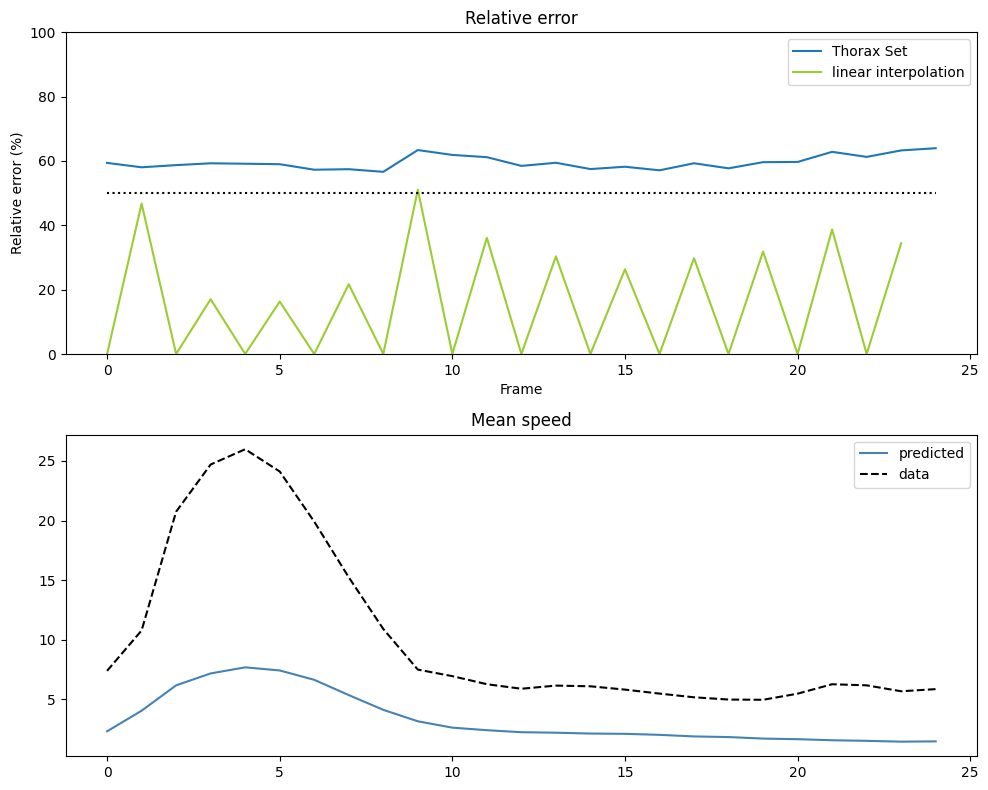

In [100]:
#calculate relative error
rel_error = calculate_relative_error_normalized(data_predicted["u"], data_predicted["v"], data_predicted["w"], data_1["u"], data_1["v"] , data_1["w"], data_1["mask"])
rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], data_1["u"], data_1["v"] , data_1["w"], data_1["mask"])


data_1['mean_speed'] = calculate_mean_speed(data_1["u_fluid"], data_1["v_fluid"] , data_1["w_fluid"], data_1["mask"])
data_predicted['mean_speed'] = calculate_mean_speed(data_predicted["u_fluid"], data_predicted["v_fluid"] , data_predicted["w_fluid"], data_1["mask"])
interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], data_1["mask"])

plt.subplot(2, 1, 1)
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = 'Thorax Set')
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Mean speed')
plt.plot(calculate_mean_speed(data_predicted["u_fluid"], data_predicted["v_fluid"], data_predicted["w_fluid"],data_1["mask"]), label = 'predicted', color= 'steelblue')
plt.plot(calculate_mean_speed(data_1["u_fluid"], data_1["v_fluid"], data_1["w_fluid"],data_1["mask"]),'--', label = 'data', color= 'black')
plt.legend()
plt.tight_layout()
plt.show()

## others

In [ ]:


@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 2, 1)
    plt.imshow(data_1['u'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Noisy')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data_2['u'][frame//2, x, :, :],vmin=min_v['u'], vmax = max_v['u'])
    plt.title('Sinc upsampled')
    plt.axis('off')
    plt.show()

In [ ]:
data_1['speed']   = np.sqrt(data_1["u"]**2 + data_1["v"]**2 + data_1["w"]**2)
data_2['speed']   = np.sqrt(data_2["u"]**2 + data_2["v"]**2 + data_2["w"]**2)
# print(np.min(data_1['speed'][40, 25, :,:]), np.max(data_1['speed'][40, 25, :,:]))
slice_idx = np.index_exp[6,34, :, :]

min_v = {}
max_v = {}

# min_v['speed'] = np.quantile(data_2['speed'][slice_idx].flatten(), 0.1)#np.min(data_2['speed'][slice_idx] )#
max_v['speed'] = np.quantile(data_2['speed'][slice_idx].flatten(), 0.7)#np.max(data_2['speed'][slice_idx] )#

im = data_2['speed'][slice_idx]

plt.figure()
ax = plt.gca()
im1 = ax.imshow(im, vmin= 0, vmax=max_v['speed'])
# plt.imshow(im, vmin= 0, vmax=max_v['speed'])
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im1, cax=cax)
# plt.colorbar()
#plt.colorbar(im,fraction=0.046, pad=0.04) 
plt.savefig('../results/data/Model1_speed_viridis_LR.png',bbox_inches='tight')
plt.show()

In [ ]:

plt.imshow(data_1['speed'][slice_idx], vmin= 0, vmax=max_v['speed'])
plt.axis('off')
plt.colorbar()
plt.savefig('../results/data/Model3_speed_viridis_LR.png',bbox_inches='tight')
plt.show()

In [ ]:
# print("Difference:", np.linalg.norm(data_2['mask']- data_1['mask']))
overlap_mask= np.zeros_like(data_1['u'])
overlap_mask[np.where(data_1['u'] != 0)] = 1
overlap_mask[np.where(data_1['v'] != 0)] = 1
overlap_mask[np.where(data_1['w'] != 0)] = 1


print(np.linalg.norm(overlap_mask - data_1['mask']))
print(np.count_nonzero(data_2['mask']- data_1['mask']))
print('Shape ', data_2['mask'].shape, 'total number of pixels: ', np.prod(data_2['mask'].shape), ' i.e.', np.prod(data_2['mask'].shape)/np.count_nonzero(data_2['mask']- data_1['mask']), ' %' )

In [ ]:
temporal_mask = data_1['mask']
def get_bounds(binary_mask):

    core_mask = binary_erosion(binary_mask)
    boundary_mask = mask - core_mask
    # kernel_x = np.array([[-1,1]])
    # kernel_y = kernel_x.transpose()

    # boundary = np.abs(convolve2d(binary_mask, kernel_x, mode ='same')) + np.abs(convolve2d(binary_mask, kernel_y, mode = 'same' ))
    # boundary[np.where(boundary !=0)] = 1
    return boundary_mask, core_mask
#get boundary points
bounds, inner_mask = get_bounds(temporal_mask)# = #np.zeros_like(temporal_mask)
# for t in range(temporal_mask.shape[0]):
#     for i in range(temporal_mask.shape[0]):
#         bounds[t, i, :, :] = get_bounds(temporal_mask[t, i, :, :])

bounds_mask = bounds.copy()
# inner_mask = np.asarray(temporal_mask, dtype= float) - np.asarray(bounds_mask, dtype = float)
# inner_mask[np.where(inner_mask != 0 )] = 1
print(np.unique(inner_mask, return_counts=True),np.unique(temporal_mask, return_counts=True),np.unique(bounds_mask, return_counts=True), bounds_mask.shape, temporal_mask.shape)
print(np.count_nonzero(inner_mask))
print(np.unravel_index(np.argmax(inner_mask), shape = inner_mask.shape))
print(np.linalg.norm((inner_mask + bounds) - temporal_mask))
@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    diff = temporal_mask - bounds
    plt.subplot(1, 3, 1)
    plt.imshow(data_1['mask'][frame, x, :, :] )#vmin=min_v, vmax= max_v)
    plt.title('Dynamical Mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(bounds[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Boundary')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('inner mask')
    plt.axis('off')
    plt.show()

In [ ]:
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_1[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_1[vel][np.where(temporal_mask !=0)].flatten(), 0.99)
@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    vel = 'u'
    diff = data_1[vel] - data_2[f'{vel}_fluid']
    
    plt.subplot(1, 3, 1)
    plt.imshow(data_1[vel][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('HR')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(data_2[f'{vel}_fluid'][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('LR noisy mask region')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Difference within mask')
    plt.axis('off')
    plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='red', label = 'not radial')   
plt.hist(p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'radial')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Distribution of velocity values in fluid region without outliers - radial")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten() - p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='blue', label = 'difference')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Difference")
plt.legend()

In [ ]:
data_dir = '../data/CARDIAC'
    
# ---- Patch index files ----
training_file = '{}/Temporal14MODEL12_2mm_step2.csv'.format(data_dir)

# Hyperparameters optimisation variables
epochs =  1
batch_size =10

patch_size = 14
res_increase = 2


# Load data file and indexes
trainset = load_indexes(training_file)

# ----------------- TensorFlow stuff -------------------
# TRAIN dataset iterator
z = PatchHandler4D(data_dir, patch_size, res_increase, batch_size)
trainset = z.initialize_dataset(trainset, shuffle=False, n_parallel=2)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    start_time = time.time()
    for i, data_pairs in enumerate(trainset):
        start_loop = time.time()
        
        a = data_pairs
        #check if datapairs align
        lr_u, hr_u_mask, mask = check_compatibility(a)

        message = f"Iteration {i+1}   - batch {time.time()-start_loop:.4f} sec {time.time()-start_time:.1f} secs"
        print(f"\r{message}", end='')
        print(' ________________________')
        #break
        
print("\nDone")#


In [ ]:
#show_timeframes(gt,lr,  pred,mask, rel_error, dt,  timepoints, axis, idx, save_as = "Frame_comparison.png")
# check interpolation result


p1 = data_1['u_fluid']#lr['u']
p2 = interpolate_linear['u_fluid'] #temporal_linear_interpolation(lr["u"],gt["u"].shape)
p3 = interpolate_linear['v']#temporal_cubic_interpolation(lr["u"],gt["u"].shape)
p4 = p2.copy()
#p3[::2, :, :, :] -= p1
p4 -= p1
print("shapes_", p1.shape, p2.shape, p3.shape)

# min_v = -1#np.min(hr_u_downsampled)
# max_v = 1#np.max(hr_u_downsampled)
# #p3[np.where(p3 !=0)] = 1


@widgets.interact(frame=(0, p2.shape[0]-1), x = (0, p2.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    #plt.imshow(p1[frame//2, x, :, :])#, vmin=min_v, vmax= max_v)
    # if frame%2 == 0:
    #     plt.imshow(p1[frame//2, x, :, :])#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    # else:
    #     plt.imshow(np.zeros_like(p1[frame//2, x, :, :]))#, vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.imshow(p1[frame, x, :, :])
    plt.title("data")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Linear interpolation")
    plt.axis('off')

    # plt.subplot(1, 4, 3)
    # plt.imshow(p3[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    # plt.title("Cubic interpolation")
    # plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p4[frame, x, :, :])#, vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



In [ ]:
p1 = mask
p2 = hr_u_mask
p3 = mask-hr_u_mask
print("shapes_", p1.shape, p2.shape, p3.shape)

min_v = -1#np.min(hr_u_downsampled)
max_v = 1#np.max(hr_u_downsampled)
#p3[np.where(p3 !=0)] = 1
overlap_masks = np.count_nonzero(p3)
print("Check compatibility of masks! Nonzero difference:", overlap_masks, '/', np.prod(list(hr_u_mask.shape)), 'i.e. ', 100*overlap_masks/np.prod(np.array(hr_u_mask.shape)) ,"%") 


@widgets.interact(frame=(0, p1.shape[0]-1), x = (0, p1.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    plt.imshow(p1[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title('Gt mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title("Non zero values for hr data")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p3[frame, x, :, :], vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()